<a href="https://colab.research.google.com/github/SLTHRN/Heart_disease_ML/blob/main/Multi-Class%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
########################
### IMPORT LIBRARIES
########################

import csv
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn

import time

import csv
from google.colab import drive
drive.mount('/content/drive')

import random

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
### IMPORTING CSV FILE FROM GOOGLE DRIVE

#FILE LOCATION IN GOOGLE DRIVE
directory = '/content/drive/MyDrive/APS360PROJECT/New data.csv'

In [3]:
### DEFINING FULLY CONNECTED NN MODEL NETWORK

import torch
import torch.nn as nn
import torch.nn.functional as F

#DEFINING A 3 LAYER FULLY CONNECTED MODEL
class neuralNetwork(nn.Module):

  def __init__(self):
    super(neuralNetwork, self).__init__()
    self.layer1 = nn.Linear(13,50)
    self.layer2 = nn.Linear(50,70)
    self.layer3 = nn.Linear(70,5)

  def forward(self, x):
    activation1 = self.layer1(x)
    activation1 = F.relu(activation1)
    activation2 = F.relu(self.layer2(activation1))
    output = self.layer3(activation2)
    return output

In [4]:
### LOADING CSV FILE FROM DIRECTORY

def load_csv(directory):
  file = open(directory, "r")
  retrieved = csv.reader(file)

  data_size = -1
  dictionary = {}
  data = []

  for row in retrieved:
    data_size+= 1
    if data_size == 0:
      for i in range(len(row)):
        dictionary[i] = row[i]
    else:
      data.append(row)

  return data_size, data, dictionary

In [5]:
### DATA STRING TO FLOAT

def str_to_flt(data):
  fail_count = 0

  for i in range(len(data)):
    row = data[i]
    new_row = []
    for j in range(len(row)):
      if row[j].isnumeric():
        new_row.append(float(row[j]))
      else:
        test = row[j].split('.')
        if len(test) == 2 and (test[0].isnumeric() and test[1].isnumeric()):
          new_row.append(float(row[j]))
        else:
          fail_count += 1
          print('!!!!!! Not Numeric, count:' + str(fail_count))
          new_row.append(row[j])
    data[i] = new_row
  return data

In [6]:
### GET LABELS

def seperate_labels(data):
  labels = []

  for row in data:
    labels.append(int(row[-1]))
    del row[-1]

  return data, labels

In [7]:
### NEW SAMPLER GENERATION

def get_samplers(data_size, labels, keep_fours = False, zero_balance = True, original_method = False, length_as_min = True,length_as_ones = True, limit = 80):
  # NOTE THAT FOR ACCURAT COMPARISON BETWEEN THIS AND BINARY MODEL, USE original_method = True SHOULD BE USED, IN ORDER TO KEEP SAMPLING METHOD CONSISTENT FOR MORE RELIABLE PERFORMANCE COMPARISONS
  # WHEN original_method = False, SAMPLING METHOD BEING USED WAS ONLY IMPLEMENTED FOR OBSERVATIONS ON MODEL PERFORMANCES WITH DIFFERENT METHODS OF DATA SAMPLING
  zeros, ones, twos, threes, fours = [], [], [], [], []
  for i in range(len(labels)):
    if labels[i] == 0.0:
      zeros.append(i)
    elif labels[i] == 1.0:
      ones.append(i)
    elif labels[i] == 2.0:
      twos.append(i)
    elif labels[i] == 3.0:
      threes.append(i)
    elif labels[i] == 4.0:
      if keep_fours:
        fours.append(i)
  if zero_balance:
    if length_as_min:
      discriminator = return_min_length(zeros, ones, twos, threes, fours)
      if keep_fours:
        index = get_shuffled(zeros[:discriminator], ones[:discriminator], twos[:discriminator], threes[:discriminator], fours[:discriminator])
      else:
        index = get_shuffled(zeros[:discriminator], ones[:discriminator], twos[:discriminator], threes[:discriminator], [])
    elif length_as_ones:
      discriminator = int(len(ones))
      index = get_shuffled(zeros[:discriminator], ones, twos, threes, fours)
    else:
      index = get_shuffled(zeros[:limit], ones, twos, threes, fours)
  elif original_method:
    torch.manual_seed(0)
    index = torch.randperm(data_size)
  else:
    index = get_shuffled(zeros, ones, twos, threes, fours)
  
  end_training = int(len(index)*0.6)
  end_validation = end_training+int(len(index)*0.2)

  training_sampler = torch.tensor(index[:end_training])
  validation_sampler = torch.tensor(index[end_training:end_validation])
  testing_sampler = torch.tensor(index[end_validation:])

  return training_sampler, validation_sampler, testing_sampler

In [8]:
### GET MIN LENGTH OF FIVE LISTS (THAT IS NOT ZERO)

def return_min_length(zeros, ones, twos, threes, fours):
  min = len(zeros)
  if min == 0:
    print("error, no labels as 0 found")
  a = [len(zeros), len(ones), len(twos), len(threes), len(fours)]
  for i in a:
    if (i < min) and (i > 0):
      min = i
  return min

In [9]:
### SHUFFLE ORDER OF FIVE INPUT LISTS, TO RANDOMIZE ORDERS FOR SAMPLING

def get_shuffled(zeros, ones, twos, threes, fours):
  for element in ones:
    zeros.append(element)
  for element in twos:
    zeros.append(element)
  for element in threes:
    zeros.append(element)
  for element in fours:
    zeros.append(element)
  random.seed(10)
  random.shuffle(zeros)
  return zeros

In [10]:
### GENERATING DATA LOADERS

def get_loaders(data, sampler, batch_size = 64):
  dataset = torch.tensor(data)

  loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)
  
  return loader

In [11]:
### DISPLAY ALL DATA IN A GIVEN LOADER

def display_loader(loader):
  for stuff in loader:
    print(stuff)

In [12]:
### CALCULATE ACCURACY OF MODEL

def get_accuracy(model, d_loader, l_loader, show_data = False):
  correct = 0
  total = 0

  for (data, label) in zip(d_loader, l_loader):
    output = model(data)
    pred = output.max(1)[1]
    if show_data:
      print("The predictions are: {}".format(pred))
      print("The labels are: {}".format(label))
    for i in range(len(pred)):
      total += 1.0
      if label[i] == pred[i]:
        correct += 1.0
  return correct/total

In [13]:
### MODEL TRAINING

def training(t_loader, t_label_loader, v_loader, v_label_loader, epochs=10, learning_rate=0.001):
  n = 0
  iters, losses, training_accuracy, validation_accuracy = [], [], [], []

  model = neuralNetwork()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  print("Starting training")
  start_time = time.time()
  for epoch in range(epochs):
    for (data, label) in zip(t_loader, t_label_loader):
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters.append(n)
      losses.append(float(loss)/batch_size)
      training_accuracy.append(get_accuracy(model, t_loader, t_label_loader))
      validation_accuracy.append(get_accuracy(model, v_loader, v_label_loader))
      n += 1

  end_time=time.time()
  print("Done training, time elapsed: {:.2f} seconds".format(end_time-start_time))
  print("Number of iterations: {}".format(iters[-1]+1))
  print("Number of epochs: {}".format(epochs))
  plt.title("Training")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracies")
  plt.plot(iters, validation_accuracy, label = "Validation")
  plt.plot(iters, training_accuracy, label = "Training")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.show

  print("Final loss: {}".format(losses[-1]))
  print("Final training accuracy: {}".format(training_accuracy[-1]))
  print("Final validation accuracy: {}".format(validation_accuracy[-1]))
  return model

In [14]:
### GET BALANCE OF DATA

def data_balance(label_loader, training = False, validation = False, testing = False, get_total = False, get_ones = False, get_twos = False, get_threes = False, get_fours = False):
  num_zeros, num_ones, num_twos, num_threes, num_fours, total = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
  for batch in label_loader:
    for element in batch:
      total += 1.0
      if element == 0.0:
        num_zeros += 1.0
      elif element == 1.0:
        num_ones += 1.0
      elif element == 2.0:
        num_twos += 1.0
      elif element == 3.0:
        num_threes += 1.0
      elif element == 4.0:
        num_fours += 1.0
  if training:
    data = "training"
  elif validation:
    data = "validation"
  elif testing:
    data = "testing"
  else:
    data = "misc."
  print("Percentage of {} data with label 0: {}%".format(data, num_zeros/total))
  if get_ones:
    print("Percentage of {} data with label 1: {}%".format(data, num_ones/total))
  if get_twos:
    print("Percentage of {} data with label 2: {}%".format(data, num_twos/total))
  if get_threes:
    print("Percentage of {} data with label 3: {}%".format(data, num_threes/total))
  if get_fours:
    print("Percentage of {} data with label 4: {}%".format(data, num_fours/total))
  if get_total:
    print("Size of {} set: {}".format(data, int(total)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Percentage of training data with label 0: 0.5224719101123596%
Percentage of training data with label 1: 0.16853932584269662%
Percentage of training data with label 2: 0.11797752808988764%
Percentage of training data with label 3: 0.14606741573033707%
Percentage of training data with label 4: 0.0449438202247191%
Size of training set: 178
Percentage of validation data with label 0: 0.5254237288135594%
Size of validation set: 59
Percentage of testing data with label 0: 0.6%
Size of testing set: 60
Starting training
Done training, time elapsed: 16.26 seconds
Number of iterations: 1800
Number of epochs: 200


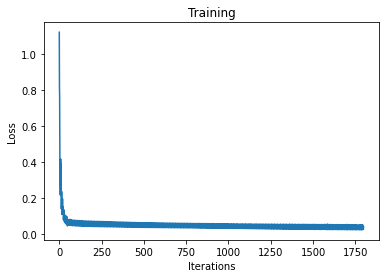

Final loss: 0.03801067769527435
Final training accuracy: 0.7191011235955056
Final validation accuracy: 0.5932203389830508
The predictions are: tensor([0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
The labels are: tensor([0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 3, 1, 0])
The predictions are: tensor([0, 0, 3, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0])
The labels are: tensor([2, 0, 2, 3, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0])
The predictions are: tensor([3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0])
The labels are: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1])
Testing accuracy: 0.6333333333333333


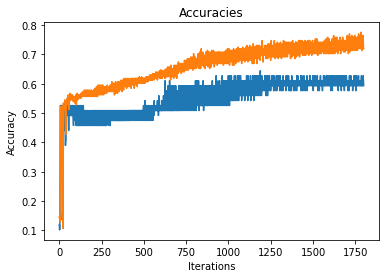

In [15]:
### RUNNING THE CODE
##################

# LOADING FILE AND GETTING SAMPLERS
data_size, data, dictionary = load_csv(directory)
data = str_to_flt(data)
data, labels = seperate_labels(data)
training_sampler, validation_sampler, testing_sampler = get_samplers(data_size, labels, keep_fours = True, zero_balance = False, original_method = True) # NOTE THAT AS original_method = True, THIS MODEL USES ALL DATA, AND SAME SAMPLING METHOD USED IN BINARY MODEL

# GETTING DATALOADERS
batch_size = 20
training_loader = get_loaders(data, training_sampler, batch_size)
training_label_loader = get_loaders(labels, training_sampler, batch_size)
validation_loader = get_loaders(data, validation_sampler, batch_size)
validation_label_loader = get_loaders(labels, validation_sampler, batch_size)
testing_loader = get_loaders(data, testing_sampler, batch_size)
testing_label_loader = get_loaders(labels, testing_sampler, batch_size)

# ANALYSING COMPOSITIONS OF EACH DATASET, BY GIVING PORTION OF DATASET WITH GIVEN TARGET LABEL
data_balance(training_label_loader, training = True, get_total = True, get_ones = True, get_twos = True, get_threes = True, get_fours = True)
data_balance(validation_label_loader, validation = True, get_total = True)
data_balance(testing_label_loader, testing = True, get_total = True)

# TRAINING MODEL
model = training(training_loader, training_label_loader, validation_loader, validation_label_loader, epochs = 200)

# MODEL PERFORMANCE ON TESTING DATASET
print("Testing accuracy: {}".format(get_accuracy(model, testing_loader, testing_label_loader, show_data = True)))